## Imports and Installs

In [ ]:
# installs
%%capture
!pip install scattertext

In [ ]:
# imports
%%capture
import nltk
from nltk import word_tokenize
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
nltk.download('punkt')
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
import spacy
import scattertext as st
from IPython.core.display import HTML
from google.colab import files
from bs4 import BeautifulSoup
import spacy
import pickle
import plotly.express as px
import pandas as pd
import numpy as np
import re
from IPython.core.display import HTML

In [ ]:
#Here we will import all relevant source texts
!wget https://raw.githubusercontent.com/gregorycrane/DHFall2021/master/texts/bury-all.xml
!git clone https://github.com/msaxton/18th-century-historians.git
!wget https://raw.githubusercontent.com/pnadelofficial/FallDHCourseMaterials/main/gibbonfortm.xml

--2023-07-05 19:05:05--  https://raw.githubusercontent.com/gregorycrane/DHFall2021/master/texts/bury-all.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12126740 (12M) [text/plain]
Saving to: ‘bury-all.xml.1’

bury-all.xml.1      100%[===================>]  11.56M  --.-KB/s    in 0.1s    

2023-07-05 19:05:05 (109 MB/s) - ‘bury-all.xml.1’ saved [12126740/12126740]

fatal: destination path '18th-century-historians' already exists and is not an empty directory.
--2023-07-05 19:05:05--  https://raw.githubusercontent.com/pnadelofficial/FallDHCourseMaterials/main/gibbonfortm.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserconten

## NER By Chapter using XML
We can extract placenames per chapter, and plot their longitudes and latitudes on a map, giving us an idea of which locations are mentioned in each chapter

In [ ]:
#import our spacy function and open our source xml
nlp = spacy.load('en_core_web_sm')

with open('gibbonfortm.xml') as gibbon_fh:
  soup = BeautifulSoup(gibbon_fh, 'lxml')

/usr/local/lib/python3.10/dist-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [ ]:
#Parse our xml
div_list = soup.findAll('div')

chapter_list = []
for div in div_list:
  div_type = div.get('subtype')
  if div_type == 'chapter':
    chapter_list.append(div)

In [ ]:
#Grab our individual chapters to analyze
chapter_number1 = "31"
chapter_number2 = "54"

for i in range(len(chapter_list)):
  chap_num = chapter_list[i].get('n')
  if chap_num == chapter_number1:
    text1 = chapter_list[i].get_text()
  if chap_num == chapter_number2:
    text2 = chapter_list[i].get_text()

#Ensure our chapters were correctly accessed
if ('text1' not in vars()) or ('text2' not in vars()):
    raise Exception("Invalid Chapter Numbers. Try Again")

In [ ]:
#Clean our chapters
full_text1 = text1.replace('\n', ' ')
full_text2 = text2.replace('\n', ' ')

In [ ]:
#function to isolate placenames per chapter
def get_placenames(chapter):
  gib_doc = nlp(chapter)

  gib_ents = []
  for ent in gib_doc.ents:
    gib_ents.append((ent.text, ent.label_))

  #isolate placenames
  places = []
  for ne in gib_ents:
    if ne[1] == 'GPE':
      places.append(ne)
    elif ne[1] == 'LOC':
      places.append(ne)

  #remove duplicates
  place_names_duplicates = [x[0] for x in places]
  place_names = []

  for x in place_names_duplicates:
    if x not in place_names:
      place_names.append(x)
    else:
      continue

  #display how many times each placename occurred in the chapter
  place_counts = []
  for place in place_names:
    place_counts.append(place_names_duplicates.count(place))
  counts_dict = dict(zip(place_names, place_counts))

  return (place_names, counts_dict)

In [ ]:
(ch1, ch1_counts) = get_placenames(full_text1)
(ch2, ch2_counts) = get_placenames(full_text2)

In [ ]:
#Pre-populated csvs with chapter locations, needed to be used while API mentioned below is down
try:
  place_df1 = pd.read_csv('places31.csv')
  place_df2 = pd.read_csv('places54.csv')
except:
  place_df1 = pd.DataFrame(columns = ['Place', 'Counts', 'Latitude', 'Longitude'])
  place_df2 = pd.DataFrame(columns = ['Place', 'Counts', 'Latitude', 'Longitude'])

In [ ]:
#function to add to our locations df
def get_pleiades_locs(countdf, df_filtered):
  df_holder = pd.DataFrame(columns = ['Place', 'Counts', 'Latitude', 'Longitude'])
  for pn in countdf:
    holder = df_filtered[df_filtered['title'] == pn].head(1)
    if not holder.empty:
      if not holder['reprLong'].isnull().values.any():
        place = holder.values[0][-1]
        latitude = holder.values[0][-3]
        longitude = holder.values[0][-2]
        count = countdf.get(pn)
        list_row = [place, count, latitude, longitude]
        df_holder.loc[len(df_holder)] = list_row
  return df_holder

In [ ]:
#add locations to these DFs using the pleiades api
!wget https://raw.githubusercontent.com/pnadelofficial/LitVis/main/data/pleiades/pleiades-names.csv
df = pd.read_csv('/content/pleiades-names.csv')
df_filtered = df[["nameAttested", "nameLanguage", "nameTransliterated", "reprLat", "reprLong", "title"]]

place_df1 = place_df1.append(get_pleiades_locs(ch1_counts, df_filtered)).dropna().reset_index(drop=True)
place_df2 = place_df2.append(get_pleiades_locs(ch2_counts, df_filtered)).dropna().reset_index(drop=True)

--2023-07-05 19:05:15--  https://raw.githubusercontent.com/pnadelofficial/LitVis/main/data/pleiades/pleiades-names.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13700788 (13M) [text/plain]
Saving to: ‘pleiades-names.csv.1’

pleiades-names.csv. 100%[===================>]  13.07M  --.-KB/s    in 0.1s    

2023-07-05 19:05:15 (114 MB/s) - ‘pleiades-names.csv.1’ saved [13700788/13700788]



<ipython-input-12-4191a75fa627>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  place_df1 = place_df1.append(get_pleiades_locs(ch1_counts, df_filtered)).dropna().reset_index(drop=True)
<ipython-input-12-4191a75fa627>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  place_df2 = place_df2.append(get_pleiades_locs(ch2_counts, df_filtered)).dropna().reset_index(drop=True)


In [ ]:
#show map of 1st chapter
fig = px.scatter_geo(place_df1, lat='Latitude',lon='Longitude', hover_name='Place', size=place_df1['Counts'].tolist())
#fig.update_layout(title = 'World map', title_x=0.5)
fig.show()

In [ ]:
#show map of 2nd chapter
fig = px.scatter_geo(place_df2,lat='Latitude',lon='Longitude', hover_name='Place', size=place_df2['Counts'].tolist())
#fig.update_layout(title = 'World map', title_x=0.5)
fig.show()

### The following API is down for maintenance, but was used to search for placenames originally. Ignore following code until API is restored

In [ ]:
import requests
import time

def search_name(name, fuzzy=False, datasets=('pleiades'), from_date=-3000, to_date=2000, retry_attempts=10):
    """
    get the raw response back from peripleo as a dictionary. look here for more details: https://github.com/pelagios/peripleo/blob/main/README.md
    :param name: place name to search
    :param fuzzy: whether a fuzzy search should be performed
    :param datasets: which datasets should be included in the search
    :param from_date: start date for search
    :param to_date: end date for search
    :param retry_attempts: how many times to retry the request if it fails
    :return:
    """
    # pause execution to prevent dos'ing the GeoNames server
    time.sleep(0.3)

    # default parameters
    params = {
        'query': name,
        'types': 'place',
        'from': from_date,
        'to': to_date,
        'datasets': datasets
    }

    if fuzzy:
        params['query'] = params['query'] + '~'

    gz_url = 'http://peripleo.pelagios.org/peripleo/search'  # baseurl for peripleo search

    try:
        response = requests.get(gz_url, params=params, timeout=None)
    except requests.exceptions.Timeout as e:
        # if specified in the arguments, retry the API call on request timeout
        print(e)
        if retry_attempts > 0:
            retry_attempts -= 1
            return search_name(name, retry_attempts=retry_attempts)
        else:
            raise Exception('Timeout after specified retries.')

    if response.status_code == 200:
        return response.json()

    # for any response where the status code is not 200 ('success') retry the API call
    if retry_attempts > 0:
        retry_attempts -= 1
        return search_name(name, retry_attempts=retry_attempts)
    else:
        raise Exception('Status code: ' + str(response.status_code))

In [ ]:
# match all places nouns against the gazetteer
peripleo_results = []
num_places = len(ch1)
prev_disp_percent = 0
for i in range(len(ch1)):
    place = ch1[i]
    print(f'matching {place} against peripleo gazetteer...')
    # search has default time bounds and default dataset is Pleiades. look at the code for details
    try:
        peripleo_results.append({'token': place, 'results': search_name(place, fuzzy=False)})
    except NameError:
        print('NameError', place)
        continue
    percent_done = (i / num_places) * 100
    disp_percent = percent_done // 1
    if disp_percent > prev_disp_percent:
        print('\n' + str(disp_percent) + '% of identified places have been checked against gazetteer...\n')
        prev_disp_percent += 1

print('complete!')

matching Goths against peripleo gazetteer...


JSONDecodeError: ignored

In [ ]:
peripleo_places = [{'token': i['token'], 'place': i['results']['items'][0]} for i in peripleo_results if len(i['results']['items']) > 0]
tokens = []
names = []
longs = []
lats = []
identifiers = []
counts = []


for p in peripleo_places:
    token = p['token']
    name_s = p['place']
#     average the minimum and maximum longitudes and latitutdes
    try:
        long = ((p['place']['geo_bounds']['max_lon']) + (p['place']['geo_bounds']['min_lon'])) / 2
        lat = ((p['place']['geo_bounds']['max_lat']) + (p['place']['geo_bounds']['min_lat'])) / 2
        count = counts_dict[token]
    except KeyError:
        long = '?'
        lat = '?'
    identifier = p['place']['identifier']
    tokens.append(token)
    names.append(name_s)
    longs.append(long)
    lats.append(lat)
    identifiers.append(identifier)
    counts.append(count)

place_df = pd.DataFrame({'token': tokens, 'names': names, "latitude": lats, 'longitude': longs, "identifier": identifiers, "counts": counts})

## Extracting Dates in Text
We can extract individual dates from the text, allowing us to compare timelines mentioned in each individual chapter

In [ ]:
df = px.data.iris()
note2page = {}
firstchappages = {}
f = open('bury-all.xml')

curchap = 1
prevchap = 0
startpage = 1
firstpage = 1
for l in f:
  if(re.search('<note',l)):
    continue
  m = re.search('<p xml:id="ch([0-9]+)',l)
  if(m):
    chaps = m[1]
    curchap = int(m[1])
    if(not curchap == prevchap):
      firstchappages[curchap] = curpage
      chaplen = curpage - firstpage
      firstpage = curpage
      #print(chaps,chaplen,volpage,curchap,firstchappages[curchap])
    prevchap = curchap
  m = re.search('<pb n="(v[0-9]+p)([0-9]+)',l)
  if(m):
    curpage = int(m[2])
    volpage = m[1] + m[2]
    chappage = curchap * 1000 + (curpage-firstpage+1)*5
  while(re.search('target="(ch[^"]+)',l)):
    m = re.search('target="(ch[^"]+)',l)
    curnote = m[1]
    note2page[curnote] = chappage
    #if(curchap == 1):
      #print(curnote,curchap,firstpage,curpage,chappage)
    l = re.sub('target="(ch[^"]+)','',l,1)
f.close()
f = open('bury-all.xml')

datelist = []
chapnotelist = []
hovernames = []
for l in f:
    if(re.search('<note xml:id="ch([0-9]+)n([0-9]+)"',l)):
        m = re.search('<note xml:id="ch([0-9]+)n([0-9]+)"',l)
        noteref = 'ch' + m[1] + 'n' + m[2]
        curchap = int(m[1])
        if(not noteref in note2page):
          print('failed',noteref)
          curpage = 0
        else:
          curpage = note2page[noteref]
    if(0 and not (curchap == 54 or curchap == 31)):
        continue
    while(re.search('<date when="([0-9\-][0-9]+)"',l)):
        m = re.search('<date when="([0-9\-][0-9]+)"',l)
        #curdate = re.sub('^[0]+','',m[1])
        curdate = int(m[1])
        l = re.sub('<date when="([0-9\-]+)"',' ',l,1)
        if(curdate > -3000 and (curchap == 31 or curchap == 54)):
          #chapnotelist.append(chapnote)
          chapnotelist.append(curpage)
          datelist.append(curdate)
          hovernames.append(noteref)

f.close()


fig = px.scatter(df, x=chapnotelist, y=datelist,hover_name=hovernames).update_layout(
    xaxis_title="Chapter, Page", yaxis_title="Date"
)
fig.show()

## Topic Modeling
By generating 2 topics from our 2 separate chapters, we hope that we can generate lists of unique words per chapter, giving us a loose summary.

In [ ]:
with open('gibbonfortm.xml') as gibbon_fh:
  soup_chapter = BeautifulSoup(gibbon_fh, features="xml")

In [ ]:
div_list = soup.findAll('div')

chapter_list = []
for div in div_list:
  div_type = div.get('subtype')
  if div_type == 'chapter':
    chapter_list.append(div)

In [ ]:
#Grab our individual chapters to analyze
chapter_number1 = "31"
chapter_number2 = "54"

for i in range(len(chapter_list)):
  chap_num = chapter_list[i].get('n')
  if chap_num == chapter_number1:
    text1 = chapter_list[i].get_text()
  if chap_num == chapter_number2:
    text2 = chapter_list[i].get_text()

#Ensure our chapters were correctly accessed
if ('text1' not in vars()) or ('text2' not in vars()):
    raise Exception("Invalid Chapter Numbers. Try Again")

#Clean our chapters
full_text1 = text1.replace('\n', ' ')
full_text2 = text2.replace('\n', ' ')

#ch1l = full_text1.split()
#ch2l = full_text2.split()
#both_chapters_list = ch1l + ch2l

ch_dict = {"1": full_text1, "2": full_text2}
chdf = pd.DataFrame.from_dict(ch_dict, orient='index').rename(columns={0:'ChapterText'})
display(chdf)

,ChapterText
1,CHAPTER XXXI Invasion of Italy by Ala...
2,CHAPTER LIV Origin and Doctrine of th...


In [ ]:
tfidf = TfidfVectorizer(max_df=0.9, min_df=1, stop_words='english')
dtm_nmf = tfidf.fit_transform(chdf['ChapterText'])
dtm_nmf

#By only giving it 2 n_components, we hope that it will create 2 groups, with each group perfectly matching one of the 2 chapters given
nmf_model = NMF(n_components=2,random_state=42)
nmf_model.fit(dtm_nmf)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:124: RuntimeWarning:

invalid value encountered in sqrt



NMF(n_components=2, random_state=42)

In [ ]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index+1}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #1
['spain', 'citizens', 'adolphus', 'senate', 'gaul', 'ravenna', 'barbarian', 'time', 'king', 'romans', 'public', 'gothic', 'alaric', 'honorius', 'goths']


THE TOP 15 WORDS FOR TOPIC #2
['greek', 'epistles', 'belief', 'reformers', 'sylvanus', 'congregations', 'theology', 'sects', 'manichaeans', 'disciples', 'images', 'catholics', 'persecution', 'doctrine', 'paulicians']




## Text Classification
We can compare the language in the book we are analyzing with the language of another book, and create a vizualization comparing the differences

In [ ]:
# load spaCy's english model and adjust piplien to deal with large amounts of data
nlp = spacy.load('en_core_web_sm')
nlp.max_length=2000000
nlp.disable_pipes('ner', 'tagger')

['ner', 'tagger']

In [ ]:
# opening the Hume text as strings, substitute whatever text interests you
with open('./18th-century-historians/hume/hume_strings', 'rb') as f:
  hume_strings = pickle.load(f)
# opening the Gibbon text as a strings, substitute whatever text interests you
with open('./18th-century-historians/gibbon/gibbon_strings', 'rb') as f:
  gibbon_strings = pickle.load(f)

In [ ]:
# ScatterText expects its data in a dataframe, so I'm putting the texts into that format
gibbon_df = pd.DataFrame(data={'author': 'Gibbon', 'text': gibbon_strings})
hume_df = pd.DataFrame(data={'author': 'Hume', 'text': hume_strings})
author_df = gibbon_df.append(hume_df)

<ipython-input-58-f74c93f96071>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
#process and display our data

# this may take a few minutes
author_corpus = st.CorpusFromPandas(author_df,
                                    category_col='author',
                                    text_col='text',
                                    nlp=nlp,
                                    ).build()

html = st.produce_scattertext_explorer(author_corpus, category='Gibbon',
                                       category_name='Gibbon',  # this is your first category of comparison
                                       not_category_name='Hume',  # this is your second category of comarison
                                       minimum_term_frequency=200,
                                       width_in_pixels=900)
HTML(html)

## Conditional frequency distribution

A **conditional frequency distribution** (cfd) is a collection of word counts for a given condition, i.e. category. Here the category is separate chapters in Gibbon, and our model will show us a relative frequency (how often a word appears in the given category relative to other categories) of words in the given chapter. We can chart what used are used most frequently by chapter. This will tell us something about the nature of each chapter.

### Pre-process text for analysis
Before doing NLP work, most texts will need to be preprocessed in different ways. You may need to **tokenize** the text, remove stopwords, or **lemmatize** the text. What you do in pre-processing depends entirely on what your project is.

In [ ]:
gibbon_corpus = PlaintextCorpusReader('./18th-century-historians/gibbon/gibbon_decline_and_fall/', '.*\.txt')

In [ ]:
# create pre_processing function
lemmatizer = WordNetLemmatizer()
def pre_process(doc):
  '''
  This function pre-processes a string by tokenizing it into words,
  removing stop words and punctuation, and lemmatizing each word.
  It reutrns a list of lemmas.
  '''
  doc_lower = doc.lower()
  tokens = word_tokenize(doc_lower)  # lowercase all words
  tokens_no_stops = [token for token in tokens if not token in stopwords.words('english')]  #remove stop words
  tokens_no_stops_no_punct = [token for token in tokens_no_stops if token.isalpha()]  # remove punctuation
  lemmas = []
  for token in tokens_no_stops_no_punct:
    lemma = lemmatizer.lemmatize(token)
    lemmas.append(lemma)
  return lemmas

In [ ]:
# This will take about 5 minutes
gibbon_docs = []
for fileid in gibbon_corpus.fileids():
  raw_text = gibbon_corpus.raw(fileid)
  lemmas = pre_process(raw_text)
  gibbon_docs.append(lemmas)

### Find the most important words by chapter in Gibbon


In [ ]:
# The tool requires a string as input rather than a list
gibbon_doc_strings = []
for doc in gibbon_docs:
  string = ' '.join(doc)
  gibbon_doc_strings.append(string)


In [ ]:
# transform corpus into a matrix of word counts
vectorizer = TfidfVectorizer(max_df=.65, min_df=1, stop_words=None,
                             use_idf= True, norm=None)
transformed_docs = vectorizer.fit_transform(gibbon_doc_strings)
transformed_docs_as_array = transformed_docs.toarray()

In [ ]:
gibbon_key_vocab_by_chap = {}
for doc, fileid in zip(transformed_docs_as_array, gibbon_corpus.fileids()):
  tf_idf_tuples = list(zip(vectorizer.get_feature_names_out(), doc))
  sorted_tf_idf_tuples = sorted(tf_idf_tuples, key= lambda x: x[1], reverse=True)
  k = fileid[23:29]
  v = sorted_tf_idf_tuples[:10]
  gibbon_key_vocab_by_chap[k] = v

In [ ]:
for k, v in gibbon_key_vocab_by_chap.items():
  result = k + ' => ' + v[0][0] + ', ' + v[1][0] + ', ' + v[2][0] + ', ' + v[3][0] + ', ' + v[4][0]
  print(result)

chap01 => hadrian, trajan, antoninus, mediterranean, antonines
chap02 => atticus, antonines, herod, gaul, athens
chap03 => hadrian, caligula, domitian, tribunitian, adoption
chap04 => commodus, pertinax, cleander, marcus, perennis
chap05 => severus, niger, albinus, pertinax, praetorian
chap06 => caracalla, macrinus, elagabalus, severus, alexander
chap07 => maximin, gordian, gordians, balbinus, maximus
chap08 => artaxerxes, parthian, zoroaster, persia, seleucia
chap09 => tacitus, rhine, warrior, reindeer, iron
chap10 => goth, valerian, gallienus, decius, sapor
chap11 => aurelian, zenobia, claudius, palmyra, tetricus
chap12 => probus, carus, carinus, tacitus, aurelian
chap13 => diocletian, maximian, galerius, tiridates, carausius
chap14 => licinius, maxentius, galerius, maximian, maximin
chap15 => christianity, primitive, jew, doctrine, gentile
chap16 => persecution, galerius, edict, diocletian, cyprian
chap17 => praefects, byzantium, capitation, praetorian, indiction
chap18 => constanti

In [ ]:
# explore vocabulary
gibbon_key_vocab_by_chap['chap16']  # <-- you can investigate other chapters

[('persecution', 155.43864657400138),
 ('galerius', 121.49453393877634),
 ('edict', 110.04987891204898),
 ('diocletian', 107.00509529568842),
 ('cyprian', 104.70101241711441),
 ('martyr', 101.46903778032578),
 ('maximin', 80.06548008367572),
 ('martyrdom', 67.51687454474039),
 ('sect', 63.01100139839618),
 ('christianity', 57.160319936476284)]

### CFD and Plot

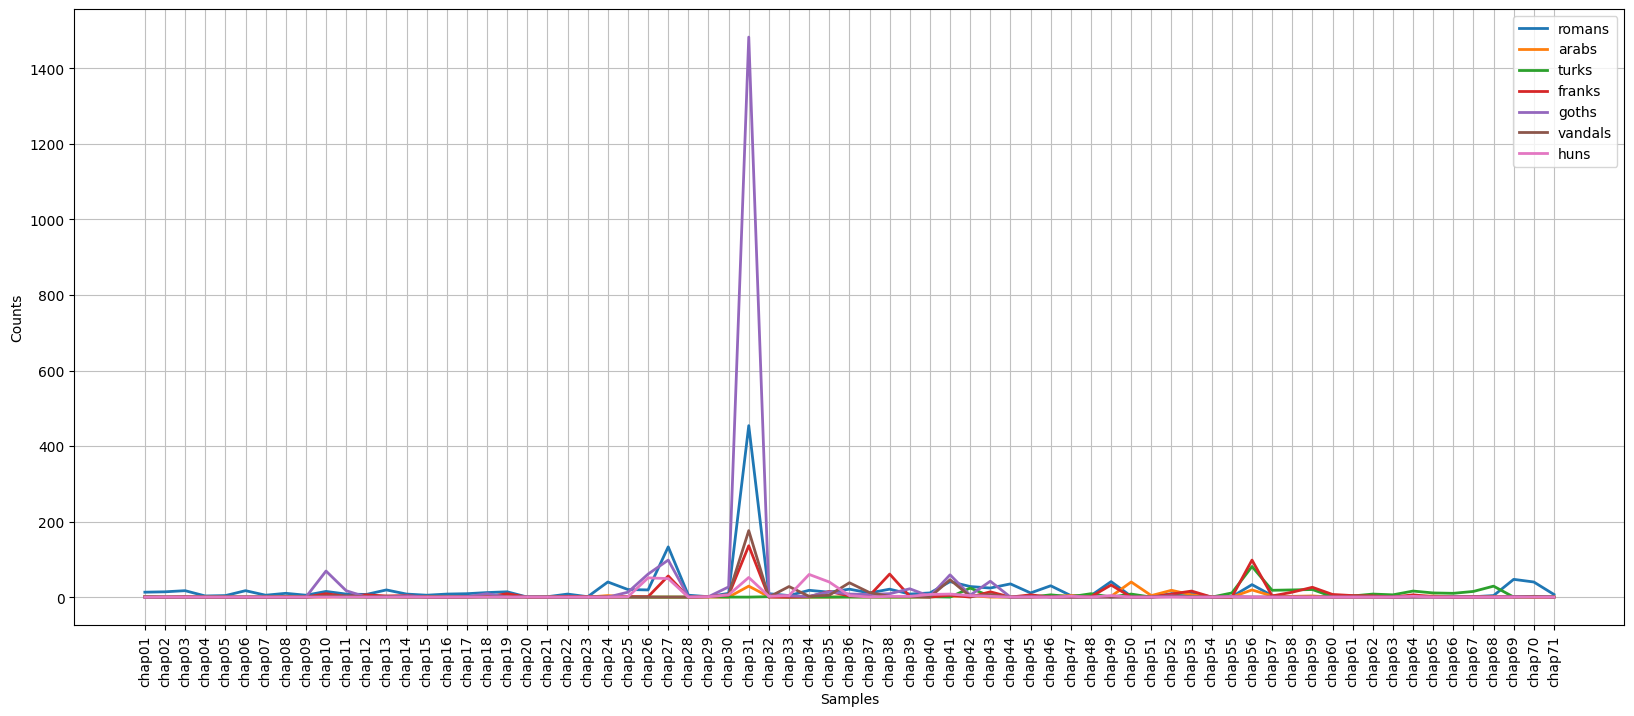

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
# conditional frequency distribution
cfd = nltk.ConditionalFreqDist(
    (target, fileid[23:29])  # just display the chapter (i.e. "chap01")
    for fileid in gibbon_corpus.fileids()
    for word in gibbon_corpus.words(fileid)
    for target in ['romans', 'franks', 'huns', 'goths', 'vandals', 'arabs', 'turks',]  # <-- instert token(s) to explore (lowercase)
    if word.lower().startswith(target)
)
# display plot
plt.figure(figsize=(20, 8))  # this expands the plot to make it more readable
cfd.plot()